# Main Causework UP2089158 UP2060325

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-05-22 13:23:26.651928: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 13:23:26.653330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:23:26.656940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 13:23:26.665950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747920206.680929    9499 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747920206.68

## Settings & Load data

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # tf will show error messages only (reduce verbosity)
sns.set_style('white')

(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape, X_test.shape)

n_labels = len(np.unique(y_train))
n_labels

(50000, 32, 32, 3) (10000, 32, 32, 3)


100

## Workflow for data

array pointer = 60
x_train[60] shape: (32, 32, 3)
label: [36]


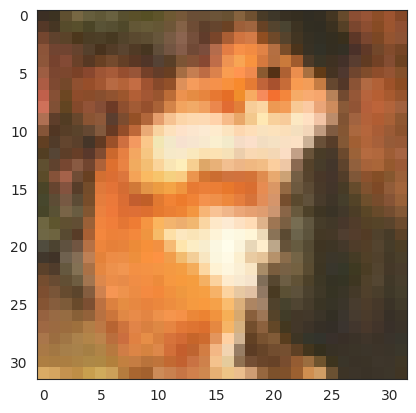

In [3]:
pointer = 60 # number of image in the dataset (remember, numbering starts from 0!)

print(f"array pointer = {pointer}")
print(f"x_train[{pointer}] shape: {X_train[pointer].shape}")
print(f"label: {y_train[pointer]}")

plt.imshow(X_train[pointer],cmap='Accent')
plt.show()

## Data preparation

In [4]:
def check_images(dataset, dataset_name):
    """
    Checks images for:
    * being an array
    * shape (28x28)
    * colour channel values
    * NaN values
    """
    invalid_count = 0  # Counter for invalid images
    valid_count = 0     # Counter for valid images

    for idx, image in enumerate(dataset):
        # Check if the image is a NumPy array
        if not isinstance(image, np.ndarray):
            print(f"{dataset_name} - Index {idx}: Not a valid image array")
            invalid_count += 1
            continue

        # Check shape (should be 28x28)
        if image.shape != (28, 28):
            print(f"{dataset_name} - Index {idx}: Incorrect shape {image.shape}")
            invalid_count += 1
            continue

        # Check if values are within expected range (0-255 for grayscale images)
        if not (image.dtype == np.uint8 and image.min() >= 0 and image.max() <= 255):
            print(f"{dataset_name} - Index {idx}: Invalid pixel values (Min: {image.min()}, Max: {image.max()})")
            invalid_count += 1
            continue

        # Check for NaN values
        if np.isnan(image).any():
            print(f"{dataset_name} - Index {idx}: Contains NaN values")
            invalid_count += 1
            continue

        valid_count += 1

    print(f"\n{dataset_name}: {valid_count} valid images, {invalid_count} invalid images")

    # Run checks on both datasets
print("Checking Images...\n")
check_images(X_train, "Train")
check_images(X_test, "Test")

Checking Images...

Train - Index 0: Incorrect shape (32, 32, 3)
Train - Index 1: Incorrect shape (32, 32, 3)
Train - Index 2: Incorrect shape (32, 32, 3)
Train - Index 3: Incorrect shape (32, 32, 3)
Train - Index 4: Incorrect shape (32, 32, 3)
Train - Index 5: Incorrect shape (32, 32, 3)
Train - Index 6: Incorrect shape (32, 32, 3)
Train - Index 7: Incorrect shape (32, 32, 3)
Train - Index 8: Incorrect shape (32, 32, 3)
Train - Index 9: Incorrect shape (32, 32, 3)
Train - Index 10: Incorrect shape (32, 32, 3)
Train - Index 11: Incorrect shape (32, 32, 3)
Train - Index 12: Incorrect shape (32, 32, 3)
Train - Index 13: Incorrect shape (32, 32, 3)
Train - Index 14: Incorrect shape (32, 32, 3)
Train - Index 15: Incorrect shape (32, 32, 3)
Train - Index 16: Incorrect shape (32, 32, 3)
Train - Index 17: Incorrect shape (32, 32, 3)
Train - Index 18: Incorrect shape (32, 32, 3)
Train - Index 19: Incorrect shape (32, 32, 3)
Train - Index 20: Incorrect shape (32, 32, 3)
Train - Index 21: Incorr

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (40000, 32, 32, 3) (40000, 1)
* Validation set: (10000, 32, 32, 3) (10000, 1)
* Test set: (10000, 32, 32, 3) (10000, 1)


## EDA

In [6]:
# Define class names. CIFER 100 labels
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [7]:
# Create a DataFrame for label frequency distribution
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

In [8]:
def count_labels(dataset, dataset_name):
    """
    Helper function to count occurrences of each label and print them
    """
    global df_freq
    unique, counts = np.unique(dataset, return_counts=True)  # Get label frequencies
    for label, frequency in zip(unique, counts):
        df_freq = pd.concat([df_freq, pd.DataFrame([{'Set': dataset_name, 'Label': class_names[label], 'Frequency': frequency}])], ignore_index=True)
        print(f"* {dataset_name} - {class_names[label]}: {frequency} images")  # Print formatted output

In [9]:
count_labels(y_train, "Train")
count_labels(y_test, "Test")
count_labels(y_val, "Validation")

* Train - apple: 377 images
* Train - aquarium_fish: 414 images
* Train - baby: 399 images
* Train - bear: 405 images
* Train - beaver: 409 images
* Train - bed: 392 images
* Train - bee: 414 images
* Train - beetle: 409 images
* Train - bicycle: 399 images
* Train - bottle: 391 images
* Train - bowl: 405 images
* Train - boy: 392 images
* Train - bridge: 400 images
* Train - bus: 403 images
* Train - butterfly: 415 images
* Train - camel: 393 images
* Train - can: 394 images
* Train - castle: 399 images
* Train - caterpillar: 394 images
* Train - cattle: 408 images
* Train - chair: 403 images
* Train - chimpanzee: 414 images
* Train - clock: 396 images
* Train - cloud: 391 images
* Train - cockroach: 391 images
* Train - couch: 395 images
* Train - crab: 401 images
* Train - crocodile: 384 images
* Train - cup: 399 images
* Train - dinosaur: 414 images
* Train - dolphin: 407 images
* Train - elephant: 404 images
* Train - flatfish: 402 images
* Train - forest: 404 images
* Train - fox

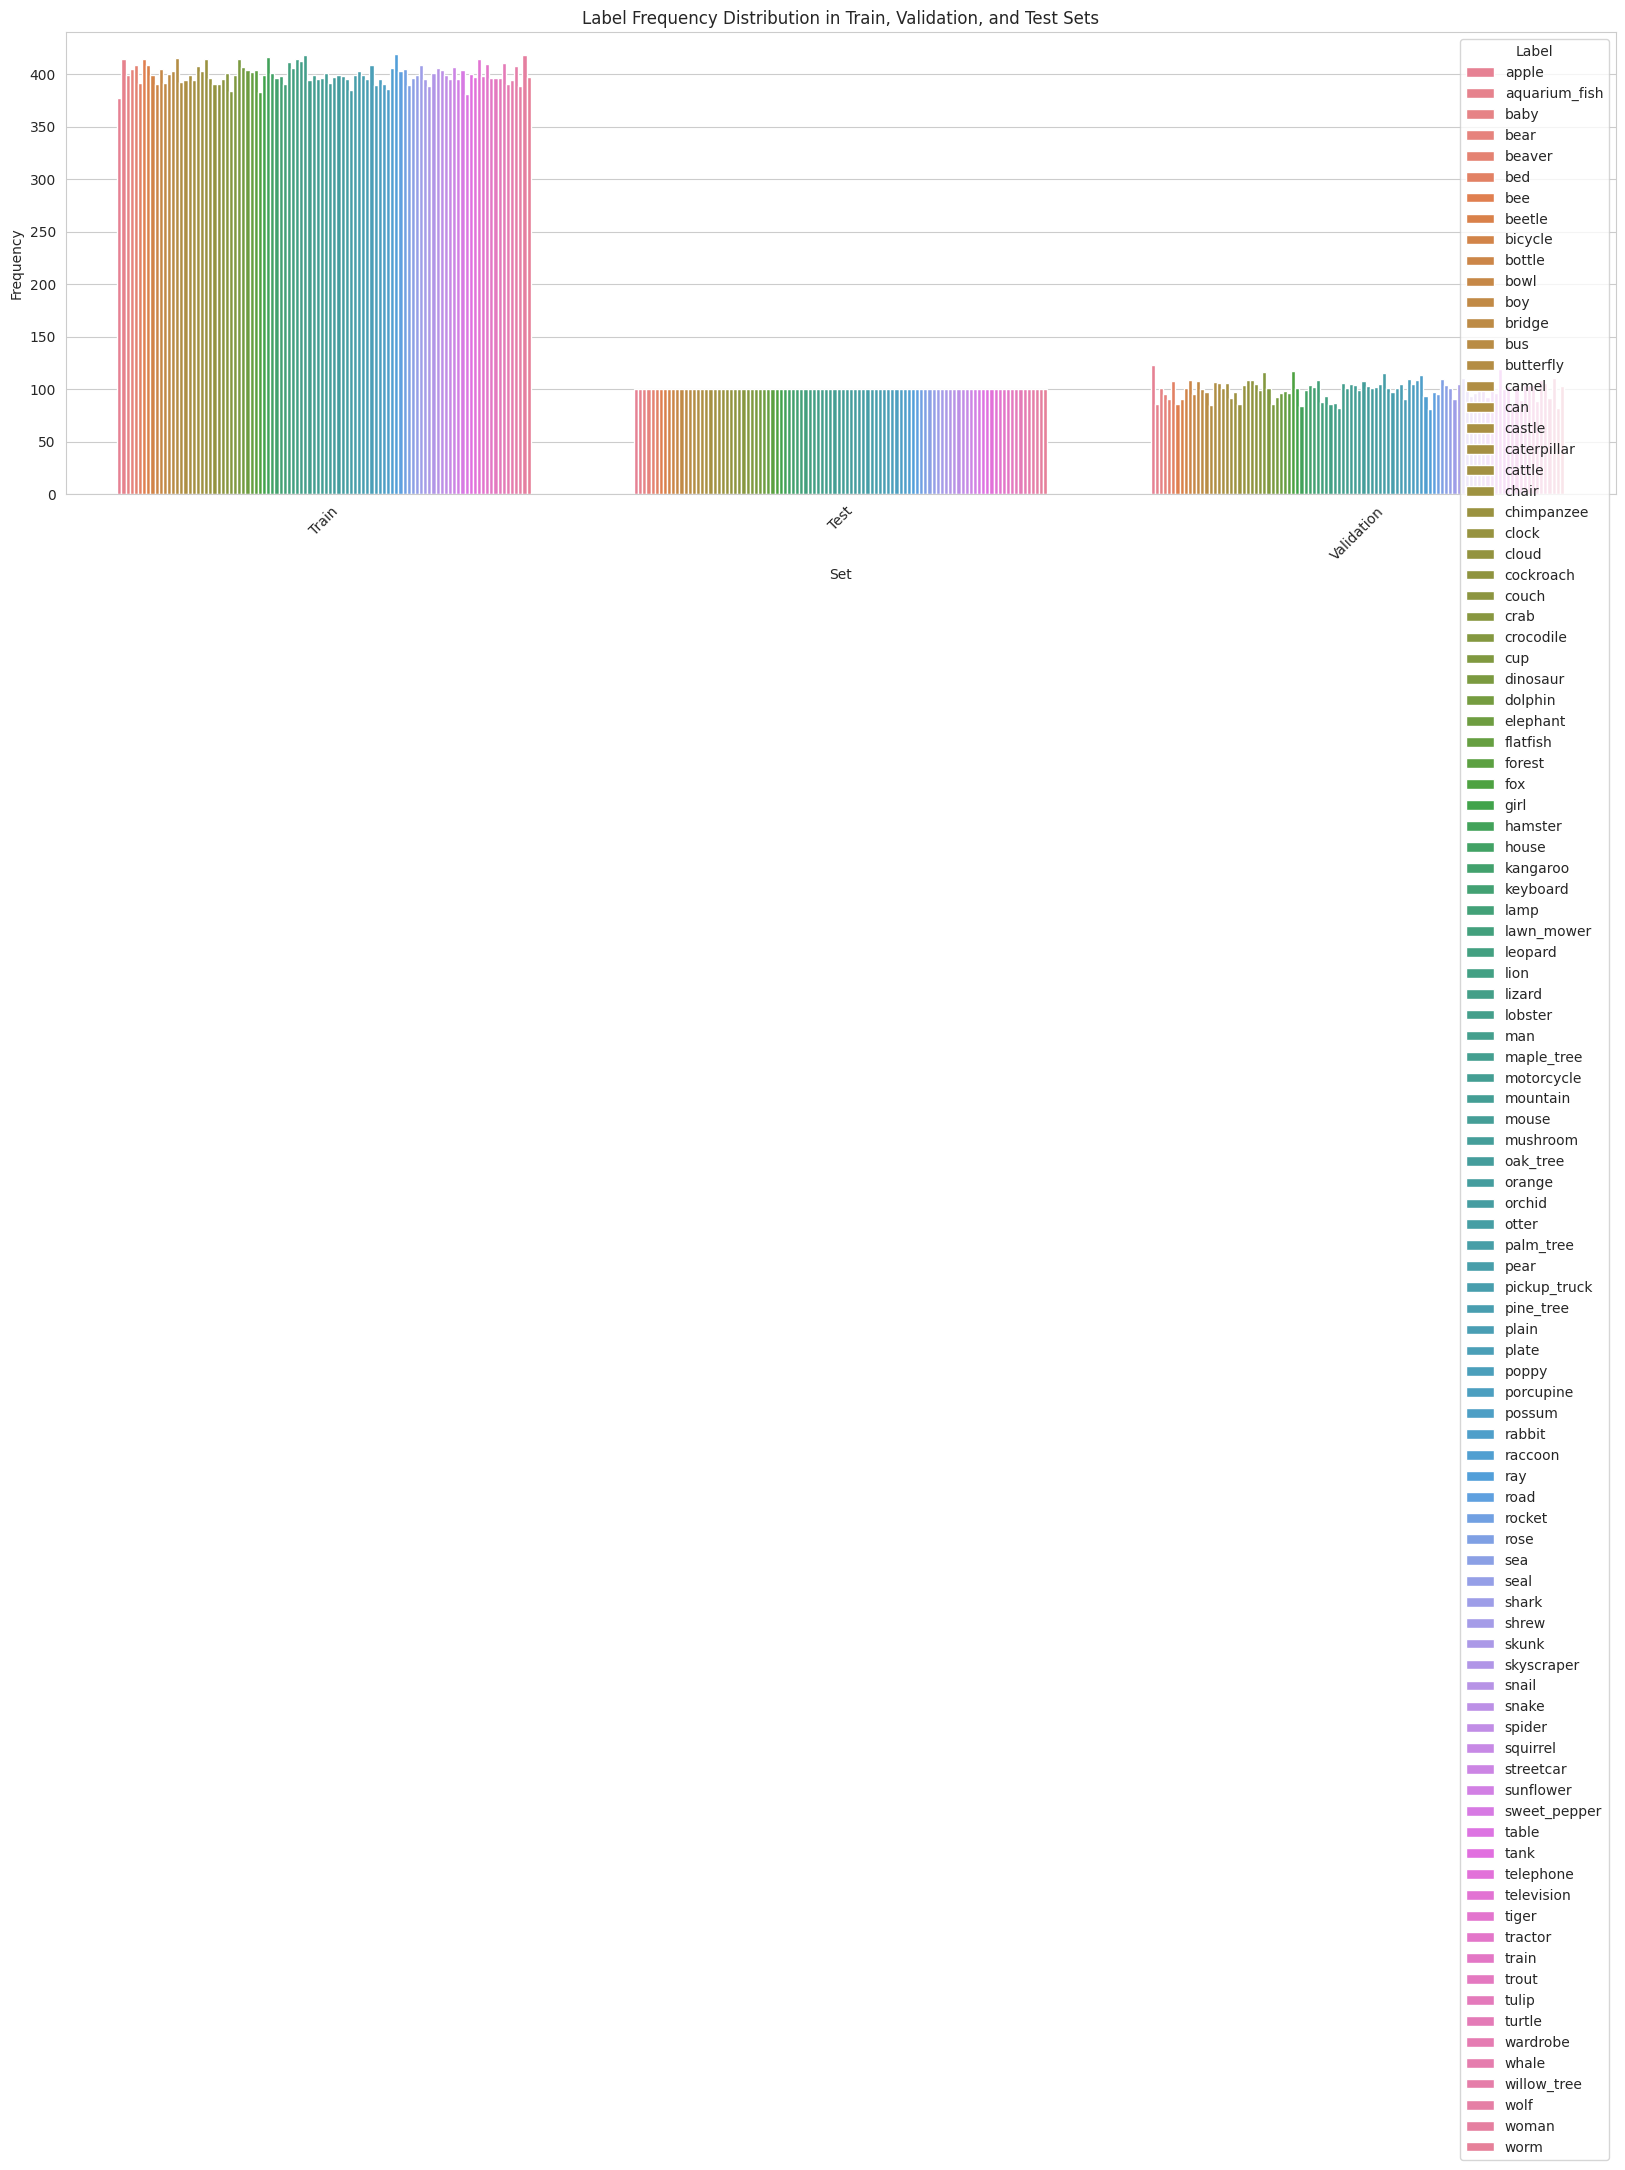

In [10]:
# Visualize the label distribution and save image
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.xticks(rotation=45)
plt.title("Label Frequency Distribution in Train, Validation, and Test Sets")
plt.show()

In [11]:
# Current data shape:
X_train.shape

(40000, 32, 32, 3)

In [12]:
# Reshape CIFER 100 data for CNN
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check the new shape
print(X_train.shape)  # Expected output: (48000, 28, 28, 1)

(40000, 32, 32, 3)


In [13]:
X_train.max()

np.float32(1.0)

In [14]:
# **Convert labels to categorical format**
n_labels = 100  # CIFER 100 classes
y_train = to_categorical(y_train, num_classes=n_labels)
y_val = to_categorical(y_val, num_classes=n_labels)
y_test = to_categorical(y_test, num_classes=n_labels)

In [15]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Building model

In [16]:
def build_tf_model(input_shape, n_labels):
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(n_labels, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [17]:
model = build_tf_model(input_shape=X_train.shape[1:], n_labels=n_labels )
model.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-22 13:27:08.612334: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,524 (349.70 KB)

 Trainable params: 89,524 (349.70 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [ ]:
model = build_tf_model(input_shape= X_train.shape[1:], n_labels=n_labels )

model.fit(x=X_train,
          y=y_train,
          epochs=4,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

## Fit the model

In [18]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [20]:
model = build_tf_model(input_shape= X_train.shape[1:], n_labels=n_labels )

model.fit(x=X_train,
          y=y_train,
          epochs=10,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.0565 - loss: 4.2762 - val_accuracy: 0.1829 - val_loss: 3.4620
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1721 - loss: 3.4777 - val_accuracy: 0.2257 - val_loss: 3.1747
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2163 - loss: 3.2070 - val_accuracy: 0.2509 - val_loss: 3.0596
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2525 - loss: 3.0477 - val_accuracy: 0.2723 - val_loss: 2.9441
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2721 - loss: 2.9406 - val_accuracy: 0.2818 - val_loss: 2.8933
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2801 - loss: 2.8699 - val_accuracy: 0.2911 - val_loss: 2.8500
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.2934 - loss: 2.8169 - val_accuracy: 0.3024 - val_loss: 2.8291
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3079 - los

## Model evaluation